# France study part III: daily climate normals

This notebook provides code for calculation of daily climate normals.
The methodology follows Rigal et al. (2018), with two key differences:
- the long-term warming function $g()$ is assumed to be known (derived from the observational constraint). In practice, we regress daily observations of a known $g$.
- we also rescaled the estimated warming to ensure the overall warming to match the warming estimated in the observational constraint.

The main statistical model writes
\begin{equation}    T_{d,y} = f(d) + g(y)h(d) + \varepsilon_{d,y},   \tag{1}  \end{equation}
where $T_{d,y}$ is the temperature of day $d$ and year $y$, $f(d)$ is the normal in a stationary climate, $g(y)h(d)$ is the change in normals induced by climate change, and $\varepsilon_{d,y}$ is internal variability.

We start with some preliminary R commands

In [5]:
library(grid)

Select smoothness for functions $f()$ and $h()$ (following Rigal et al., 2018)

In [6]:
dff = 15
dfh = 6

## I. Data + spline calculation

Load daily observed data

In [29]:
load("IT_quot.Rdata")  # variable M
period = 1947:2020
M = M[,as.character(period)]
ny = length(period)
days = dimnames(M)$day
nd = length(days)

Load the "known" $g()$ function and associated uncertainty (derived from the observational constraint)

In [30]:
load("G_cons.Rdata")  # variable G
g = G[as.character(period),"be"]  # Best-estimate of g()
G_boot = G[as.character(period),-1]  # Resampled estimates of g()

Preliminary (technical) calculation for periodic smoothing splines. 

Note: smoothing splines are easy to use in R with 'smooth.spline()'. But, we find no easy way to calculate periodic smoothing splines (which are needed here). The calculations below enable us to derive periodic smoothing splines, through the derivation of the appropriate "Hat-Matrices". There may exist another R package doing this...


In [31]:
source("spline_per.R")
# Compute peridic smoothing spline basis on 'nd' knots
l = baseSplinePer(nd)
Zp = l$Z
Gp = l$G
# For f() -- set the appropriate df and derive the Hat-Matrix 'Gamma'
rhof = dlrho(dl = dff,Zp,Gp)
Hp = t(Zp)%*%Zp + rhof * Gp
Hp1 = solve(Hp)
Gammaf = Zp %*% Hp1 %*% t(Zp)
# For h() -- set the appropriate df and derive the Hat-Matrix 'Gamma'
rhoh = dlrho(dl = dfh,Zp,Gp)
Hp = t(Zp)%*%Zp + rhoh * Gp
Hp1 = solve(Hp)
Gammah = Zp %*% Hp1 %*% t(Zp)

## II. Calculation: best-estimate


Center input function $g()$

In [32]:
gc = g - mean(g)

Day-by-day linear regression on $g()$

In [33]:
fraw = array(NA,dim=nd,dimnames=list(day=days))
hraw = array(NA,dim=nd,dimnames=list(day=days))

for (d in 1:nd){
  lm.out = lm(M[d,] ~ gc)
  fraw[d] = lm.out$coefficients[1]
  hraw[d] = lm.out$coefficients[2]
}

Periodic spline smoothing of fraw and hraw, with appropriate dofs

In [34]:
fhat = Gammaf %*% fraw
hhat0 = Gammah %*% hraw

At this stage, 'hhat0' is a first guess of $h()$. Its average $\bar{h}$ is not equal to 1, and so the annual mean warming over the period considered is estimated to be $\big( g(y_n)-g(y_1) \big) \bar{h}$.

To keep overall warming equal to that assumed in $g()$ (i.e., $g(y_n)-g(y_1)$), we normalize $h$. As $g$ was previously centered, this does not affect the average temperature over the period considered.

In [35]:
hhat = hhat0 / mean(hhat0)

We end up with estimates for $f()$ and $h()$, so all terms in Eq. (1) have been estimated.

# III. Calculation: uncertainty ranges

Uncertainty calculation below seek to sample uncertainty in $g()$, $f()$, and $h()$. (NB: '_gu' suffix in subsequent code means "$g()$ unknown").

Uncertainty in $g()$ is sampled in the variable 'G_cons' (above).

Uncertainty in $f()$ and $h()$ is assessed via a bootstrap procedure, as follows.

Initializing

In [36]:
Nboot = dim(G_boot)[2]
fraw_boot_gu = array(NA,dim=c(nd,Nboot),dimnames=list(day=days,boot=as.character(1:Nboot)))
hraw_boot_gu = array(NA,dim=c(nd,Nboot),dimnames=list(day=days,boot=as.character(1:Nboot)))

Bootstrap loop

In [37]:
for (ib in 1:Nboot) {
  if (ib%%10==0) message(ib)
  gb = G_boot[as.character(period),ib]
  gbc = gb - mean(gb)
  yb = sample(1:ny,replace=T)
  for (d in 1:nd){
    lm.out = lm(M[d,yb] ~ gbc[yb])
    fraw_boot_gu[d,ib] = lm.out$coefficients[1]
    hraw_boot_gu[d,ib] = lm.out$coefficients[2]
  }
}

10

20

30

40

50

60

70

80

90

100

110

120

130

140

150

160

170

180

190

200

210

220

230

240

250

260

270

280

290

300

310

320

330

340

350

360

370

380

390

400

410

420

430

440

450

460

470

480

490

500

510

520

530

540

550

560

570

580

590

600

610

620

630

640

650

660

670

680

690

700

710

720

730

740

750

760

770

780

790

800

810

820

830

840

850

860

870

880

890

900

910

920

930

940

950

960

970

980

990

1000



Apply periodic spline smoothing, then normalize (as in the "best-estimate" calculation)

In [38]:
fhat_boot_gu = Gammaf %*% fraw_boot_gu
hhat_boot_gu = Gammah %*% hraw_boot_gu
hhat_boot_gu_norm  = hhat_boot_gu / (rep(1,nd)%o%apply(hhat_boot_gu,2,mean))
hhat_ic_boot_gu  = apply(hhat_boot_gu_norm ,1,quantile,c(.05,.95))

## III. Plots

An example of plot.

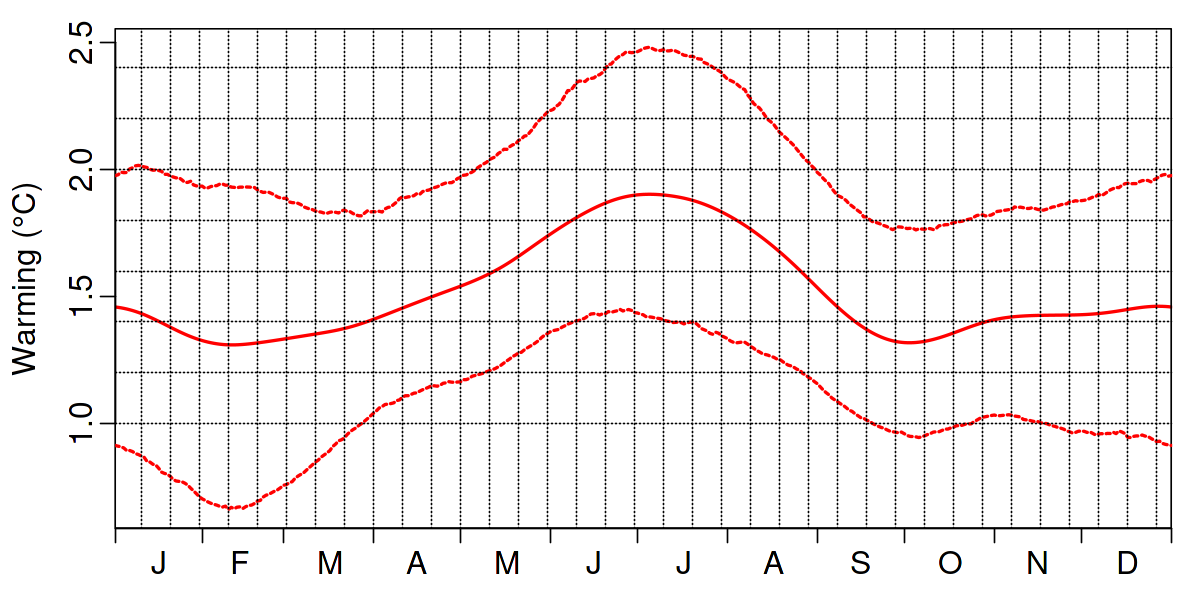

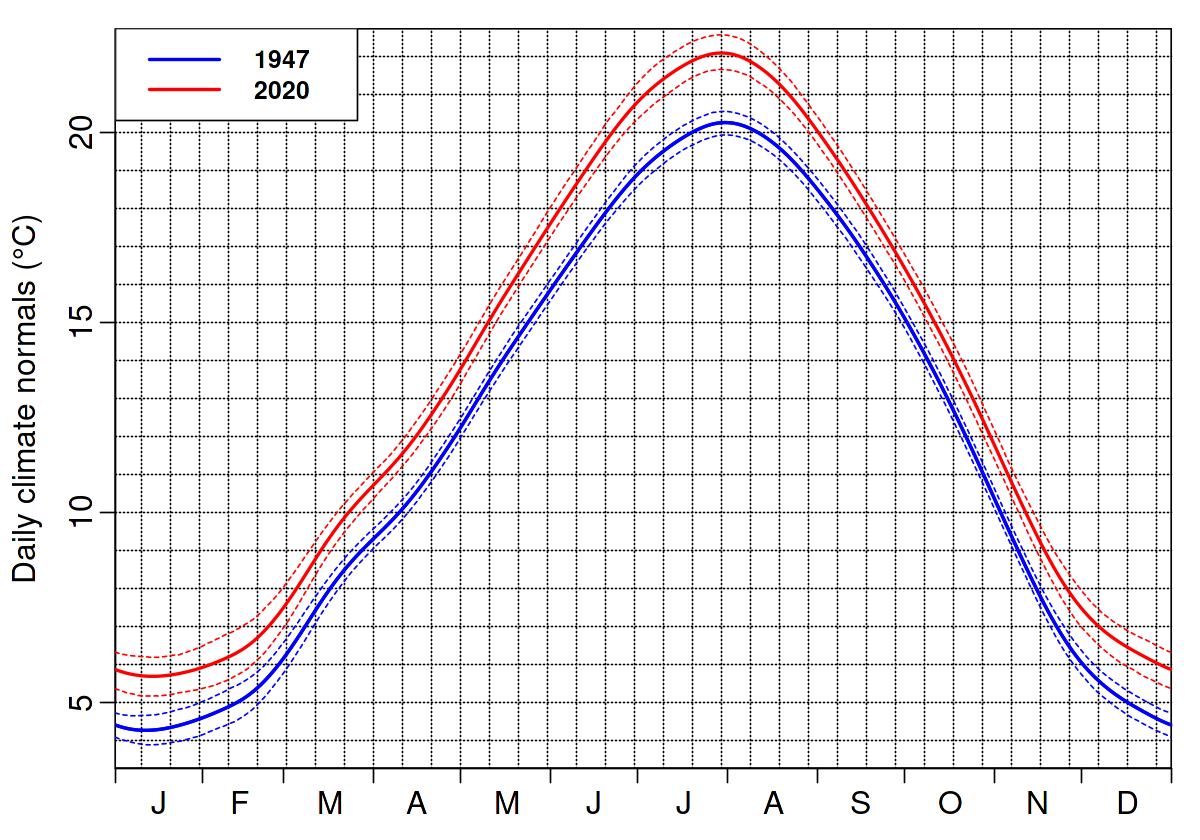

In [40]:
day_by_month=c(0,31,28,31,30,31,30,31,31,30,31,30,31)
atx = cumsum(day_by_month)
atx[1]=1
yr = as.numeric(names(g))
y1 = min(yr)
yn = max(yr)

# Delta_cycle calculation
dcycle = hhat*(g[as.character(yn)]-g[as.character(y1)])
dcycle_boot_gu = hhat_boot_gu_norm * (rep(1,365) %o% (G_boot[as.character(yn),]-G_boot[as.character(y1),]))
dcycle_ic_gu = apply(dcycle_boot_gu,1,quantile,c(.05,.95))


# Plot delta_cycle
options(repr.plot.width=10, repr.plot.height=5)
par(font=2,cex=1.2,mgp=c(2.7,.7,0),mar=c(2.5,4,1,1),cex.axis=1.3,cex.lab=1.3)
plot(dcycle,type="l",col="red",xaxt="n",ylab="Warming (°C)",lwd=2,xaxs="i",xlab="",ylim=range(dcycle_ic_gu))
matlines(t(dcycle_ic_gu),lty=2,col="red",lwd=2)
abline(h=seq(1,2.5,.2),lty=3)
abline(v=seq(0,400,10),lty=3)
axis(1,at=atx,labels=F,tick=T)
axis(1,at=atx[-1]-15,labels=c("J","F","M","A","M","J","J","A","S","O","N","D"),tick=F,mgp=c(2,.7,0))



# Old vs new normals calculations
G_bootc = G_boot[as.character(period),] - ( rep(1,ny) %o% apply(G_boot[as.character(period),],2,mean) )
old_norm_boot = fhat_boot_gu + hhat_boot_gu_norm * (rep(1,365) %o% (G_bootc[as.character(y1),]))
new_norm_boot = fhat_boot_gu + hhat_boot_gu_norm * (rep(1,365) %o% (G_bootc[as.character(yn),]))
old_norm_ic = apply(old_norm_boot,1,quantile,c(.05,.95))
new_norm_ic = apply(new_norm_boot,1,quantile,c(.05,.95))


# Plot old vs new normals
options(repr.plot.width=10, repr.plot.height=7)
par(font=2,cex=1.2,mgp=c(2.7,.7,0),mar=c(2.5,4,1,1),cex.axis=1.3)
plot(fhat+gc[as.character(y1)]*hhat,type="l",lwd=2,col="blue",ylim=c(4,22),ylab="Daily climate normals (°C)",xaxt="n",xaxs="i",xlab="")
abline(h=0:30,lty=3)
abline(v=seq(0,400,10),lty=3)
legend("topleft",names(g[c(1,ny)]),col=c("blue","red"),lwd=2,bg="white")
axis(1,at=atx,labels=F,tick=T)
axis(1,at=atx[-1]-15,labels=c("J","F","M","A","M","J","J","A","S","O","N","D"),tick=F,mgp=c(2,.7,0))
lines(fhat+gc[as.character(y1)]*hhat,type="l",lwd=2,col="blue")
lines(fhat+gc[as.character(yn)]*hhat,type="l",lwd=2,col="red")
matlines(t(old_norm_ic),lty=2,col="blue",lwd=1)
matlines(t(new_norm_ic),lty=2,col="red",lwd=1)
